# Assessing deforestation risk

In [1]:
#importing required libraries and modules
import pandas as pd
import os
import rasterio
import geopandas as gpd
from shapely.geometry import Point
from obspy.geodetics import kilometers2degrees
from rasterio.plot import show
from rasterio.mask import mask
from fiona.crs import from_epsg
import pycrs
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

## 1 Reading from the excel file the table with info about the soybean crushers

In [2]:
my_path = os.getcwd()
filename = 'SoybeanCrusherCoordinates.xlsx'
path = os.path.join(my_path, filename)
df = pd.read_excel(path)

In [3]:
df

,Soybean crusher name,Sourcing volume [metric tons],Coordinates (Lat/Long),Lat,Long,Radius [km]
0,A,150360,"-14.239691, -55.470558",-14.239691,-55.470558,150
1,B,360253,"-18.841212, -56.719678",-17.841212,-56.719678,240


## 2 Reading the GFW tree cover loss GeoTIFF file directly from the URL

In [4]:
# defining the URL of the GeoTIFF file
tree_cover_loss_url = "https://storage.googleapis.com/earthenginepartners-hansen/GFC-2022-v1.10/Hansen_GFC-2022-v1.10_lossyear_10S_060W.tif"

In [5]:
# opening the raster file and checking its attributes
tree_cover_loss = rasterio.open(tree_cover_loss_url)
tree_cover_loss.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 40000,
 'height': 40000,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00025, 0.0, -60.0,
        0.0, -0.00025, -10.0)}

## 3 Defining the supply sheds of the soybean crushers

In [6]:
def create_supply_shed_from_point(lat,lon,sourcing_radius_km):
    """ Function to define the crushers' supply sheds, based on buffers defined by its coordinates and sourcing radius. 
    The sourcing radius is converted from km to degrees, using the obspy.geodetics.kilometers2degrees function. 
    """
    crusher_coordinates = (lon,lat)
    crusher_point = Point(crusher_coordinates)
    sourcing_radius_degrees = kilometers2degrees(sourcing_radius_km)
    crusher_buffer = crusher_point.buffer(sourcing_radius_degrees)
    supply_shed = gpd.GeoDataFrame({"geometry": [crusher_buffer]}, crs="EPSG:4326")
    return supply_shed

In [7]:
# defining the supply shed buffers for crusher A and B
supply_shed_a = create_supply_shed_from_point(*list(df.loc[0][3:7]))
supply_shed_b = create_supply_shed_from_point(*list(df.loc[1][3:7]))


## 4 Clipping the tree cover loss map with the supply shed masks

In [8]:
def get_supply_shed_features(gdf):
    """Function to parse features from the supply shed buffer GeoDataFrame, to get the coordinates for clipping the tree cover 
    loss raster
    """
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [9]:
# getting the geometry of the supply shed polygons
coords_a = get_supply_shed_features(supply_shed_a)
coords_b = get_supply_shed_features(supply_shed_b)

In [10]:
def clip_raster_with_supply_shed_mask(raster_gfw, coords):
    """Function to clip the tree cover loss map with the respective supply shed masks"""
    clip_raster, clip_transform = mask(raster_gfw, coords, crop=True)
    return clip_raster, clip_transform 

In [11]:
# clipping the tree cover loss map with the supply shed buffer masks
clip_raster_a, clip_tranform_a = clip_raster_with_supply_shed_mask(tree_cover_loss, coords_a)
clip_raster_b, clip_tranform_b = clip_raster_with_supply_shed_mask(tree_cover_loss, coords_b)

<Axes: >

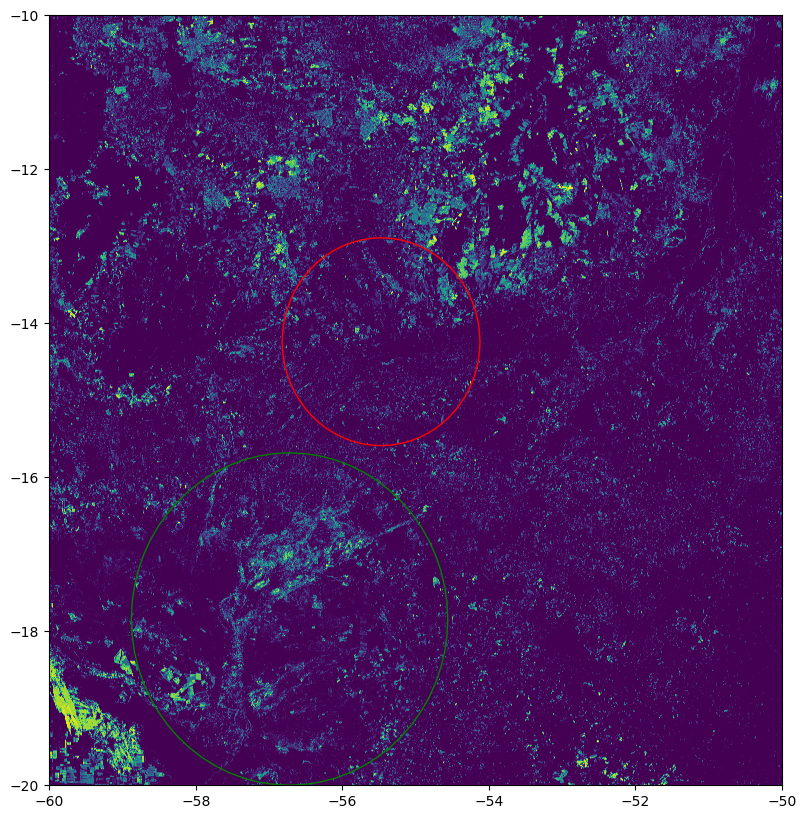

In [12]:
# plotting the tree cover loss map together with the supply shed of crusher A (red) and B (green)
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(tree_cover_loss, ax=ax)
supply_shed_a.plot(ax=ax, facecolor='none', edgecolor='red')
supply_shed_b.plot(ax=ax, facecolor='none', edgecolor='green')

## 5 Calculating deforestation risk metrics for each supply shed

In [13]:
def calculate_deforestation_metrics(clip_raster, pixel_area, sourcing_volume, radius):
    """Function to calculate deforestation risk metrics associated with a supply shed, including:
    - total tree cover loss area, i.e. the total area where forest cover loss was observed between 2003 and 2023 (in km2)
    - deforestation per unit of sourcing volume, i.e. total deforestation area divided by  metric tons of sourced soybeans (in km2/ton)
    - deforestation rate, i.e. the share of deforestation area in relation to the total area of the supply shed. 
    The total area of the supply shed (in km2) is also calculated within this function.
    """
    clip_reclass = np.where(clip_raster < 3, 0, 1)
    deforestation_area = int(np.count_nonzero(clip_reclass == 1) * pixel_area)
    deforestation_per_ton = deforestation_area / sourcing_volume
    supply_shed_area = np.pi * (radius **2)
    deforestation_rate = deforestation_area / supply_shed_area
    return deforestation_area, deforestation_per_ton, deforestation_rate, supply_shed_area

In [14]:
# specifying the pixel resolution of the raster in meters (GFW is approximately 30 meters)
pixel_resolution_meters = 30.0

#calculating the approximate area of each pixel in km2
pixel_area_km = (pixel_resolution_meters **2) / 1e6

In [15]:
# calculating deforestation risk metrices for the supply sheds of crusher A and B
deforestation_metrics_a = calculate_deforestation_metrics(clip_raster_a, pixel_area_km, df.iloc[0,1], df.iloc[0,5])
deforestation_metrics_b = calculate_deforestation_metrics(clip_raster_b, pixel_area_km, df.iloc[1,1], df.iloc[1,5])

In [16]:
print(f"The total tree cover loss area in the supply shed of crusher A is {deforestation_metrics_a[0]} km2. {os.linesep}The average tree cover loss per unit of sourcing volume is {round(deforestation_metrics_a[1],3)} km2/ton. {os.linesep}The deforestation rate is {round(deforestation_metrics_a[1],4):.1%} ")

The total tree cover loss area in the supply shed of crusher A is 8186 km2. 
The average tree cover loss per unit of sourcing volume is 0.054 km2/ton. 
The deforestation rate is 5.4% 


In [17]:
print(f"The total tree cover loss area in the supply shed of crusher B is {deforestation_metrics_b[0]} km2. {os.linesep}The average tree cover loss per unit of sourcing volume is {round(deforestation_metrics_b[1],3)} km2/ton. {os.linesep}The deforestation rate is {round(deforestation_metrics_b[1],4):.1%}")

The total tree cover loss area in the supply shed of crusher B is 17467 km2. 
The average tree cover loss per unit of sourcing volume is 0.048 km2/ton. 
The deforestation rate is 4.9%


## 6 Plotting the yearly deforestation rate for each supply shed

In [18]:
def plot_yearly_deforestation_rate(clip_raster, supply_shed_area, pixel_area, crusher_name):
    """Function to plot the yearly deforestation rate in each supply shed."""
    
    # Initializing a dictionary to store yearly tree cover loss
    yearly_deforestation_rate = {year: 0 for year in range(2003, 2023)}  # Years from 2003 to 2023
    
    # Looping through the values in the raster data
    for value in np.unique(clip_raster):
        if 3 <= value <= 22:  # Checking if the value is within the valid range
            year = value + 2000  # Mapping the value to the corresponding year
            loss_count = np.sum(clip_raster == value) # Summing the number of pixels with tree cover loss for that year
            loss_area = loss_count * pixel_area # Calculating the tree cover loss area in km2 for that year
            deforestation_rate = loss_area / supply_shed_area # Calculating the deforestation rate (%) for that year
            yearly_deforestation_rate[year] += deforestation_rate # Assigning the deforestation rate value to that corresponding year
            
    # Converting the dictionary into lists for plotting
    years = list(yearly_deforestation_rate.keys())
    deforestation_rates = list(yearly_deforestation_rate.values())
    
    # Creating a line plot to show the yearly deforestation trend
    plt.figure(figsize=(12, 6))
    plt.plot(years, deforestation_rates, marker='o', linestyle='-')
    plt.title(f"Crusher {crusher_name}: Yearly deforestation rate (2003-2022)")
    plt.xlabel('Year')
    plt.ylabel('Deforestation rate')
    plt.grid(True)
    plt.xticks(range(2003, 2023))
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.show()
    return plt.show()

In [19]:
# getting the total area of each supply shed
supply_shed_area_a = deforestation_metrics_a[3] 
supply_shed_area_b = deforestation_metrics_b[3] 

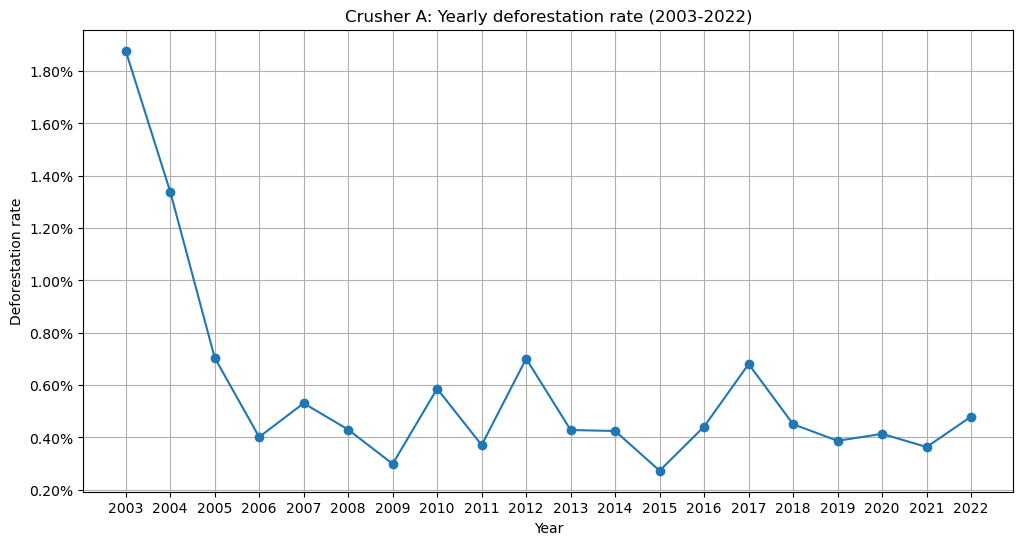

In [22]:
plot_yearly_deforestation_rate(clip_raster_a, supply_shed_area_a, pixel_area_km, "A")

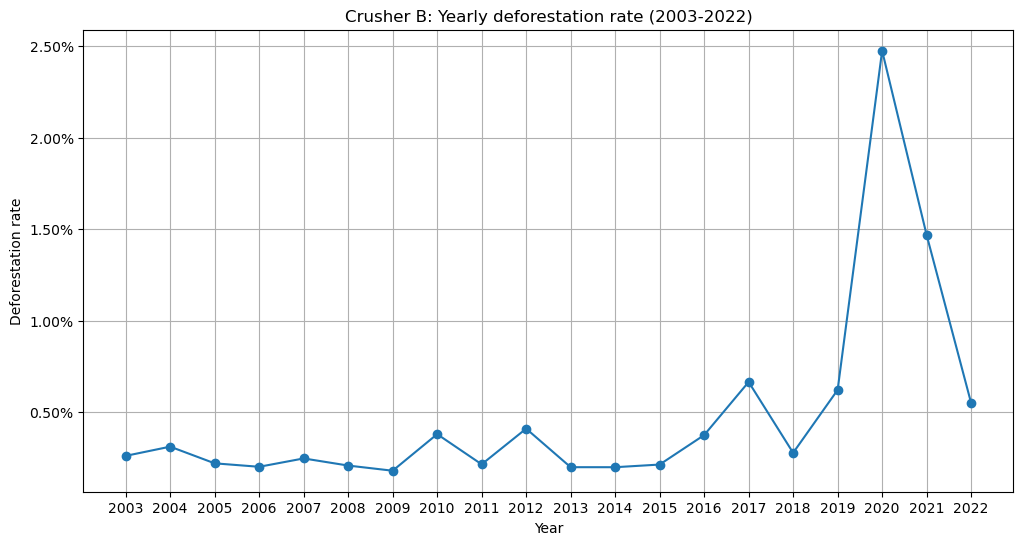

In [21]:
plot_yearly_deforestation_rate(clip_raster_b, supply_shed_area_b, pixel_area_km, "B")